In [1]:
'''
Simulate Gaussian beam with hyperboliod in one sheet
'''
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

- $r_0$: the radial disatance from z axis;  
- $z_r$: the Rayleigh range of the beam;  
- $z_f$: the z distance from the focus;  
- $theta$: the angle relative to the positive x-axis in X-Y plane;

Define two functions to calculate the coordinates and direction of a photon in a Gaussian beam:

1. **entry_cor($r_0, theta, z_r, z_f$)**: This function calculates the x and y coordinates at a given distance  $z_f$ from the focal point of the Gaussian beam, considering the Rayleigh range $z_r$.

2. **dir_zf0($r_0, theta, z_r$)**: This function computes the direction of a photon at a point ($r_0$, $theta$) on the surface of a hyperboloid, which is a shape that Gaussian beams approximate. This gives the direction vector ($v_x, v_y, v_z$) for a photon.

In [2]:
def entry_cor(r0, theta, zr, zf):

    cost = np.cos(theta)
    sint = np.sin(theta)
    t = -zf / zr #

    x = r0 * (cost - t * sint) 
    y = r0 * (sint + t * cost)
    return x, y

def dir_zf0(r0, theta, zr):

    cost = np.cos(theta)
    sint = np.sin(theta)
    l = np.sqrt(r0 * r0 + zr * zr)

    vx = -r0 * sint / l # for normalization
    vy = r0 * cost / l
    vz = zr / l

    return vx, vy, vz

In [63]:
w0 = 1  # Beam waist (1/e reduction of electric field)
df = 4  # Distance between launch plane and focus
zr = 2  # Rayleigh range (determines beam's divergence)

beam_dir = np.array([np.sqrt(0.0), np.sqrt(01.0), np.sqrt(0.0)])  # Beam direction (x, y, z)
source_pos = np.array([0, 0, 0])  # Position of the photon source
rng = np.random.default_rng()
num_phot = 5000  # Number of photons
ran1 = rng.uniform(low=0, high=1.0, size=num_phot)  # Radial distance sampling
ran2 = rng.uniform(low=0, high=1.0, size=num_phot)  # Azimuthal angle sampling


### 1. Gaussian Beam Radial Distribution

The radial intensity distribution of a Gaussian beam is given by:

$$
I(r) = I_0 \exp\left( -\frac{2r^2}{w_0^2} \right)
$$

The corresponding probability density function (PDF) for the radial position $r$ (normalized so that the total probability over the beam cross-section is 1) is:

$$
P(r) = \frac{2r}{w_0^2} \exp\left( -\frac{2r^2}{w_0^2} \right)
$$

- **$P(r)$**: Probability density function for the radial position $r$.
- **$w_0$**: Beam waist (radius where intensity falls to $1/e^2$ of its maximum value).
- The term $\frac{2r}{w_0^2}$ is the normalization factor ensuring the PDF integrates to 1 over the range $r \in [0, \infty)$.

### 2. Sampling Radial Positions Using Inverse Transform Sampling

To generate random samples $r$ that follow the PDF $P(r)$, we use the **inverse transform sampling method**. 

#### a. Compute the Cumulative Distribution Function (CDF)

The CDF $F(r)$ is obtained by integrating the PDF from 0 to $r$:

$$
F(r) = \int_0^r P(r') \, dr' = 1 - \exp\left( -\frac{2r^2}{w_0^2} \right)
$$

#### b. Generate Uniform Random Numbers

Generate a set of random numbers $U$ uniformly distributed in the interval $[0, 1)$.

#### c. Invert the CDF

Solve for $r$ in terms of $U$:

$$
U = F(r) = 1 - \exp\left( -\frac{2r^2}{w_0^2} \right)
$$

$$
-\frac{2r^2}{w_0^2} = \ln(1 - U)
$$

Since $U$ is uniformly distributed over $[0, 1)$, $1 - U$ is also uniformly distributed over $(0, 1]$. For computational convenience and to avoid taking the logarithm of zero, we can redefine $U$ to be uniformly distributed over $(0, 1]$.

Let $U' = 1 - U$, so $U'$ is uniformly distributed over $(0, 1]$:

$$
-\frac{2r^2}{w_0^2} = \ln(U')
$$

Solving for $r$:

$$
r = \frac{w_0}{\sqrt{2}} \sqrt{ -\ln(U') }
$$

in the code, $U$ is represented as `ran1`, leading to:

```python
r_samps = w0 * np.sqrt(-0.5 * np.log(ran1))


In [64]:
# r_samps = np.zeros(num_phot) + 1.0  # All photons launched at r = 1.0
r_samps = r = w0*np.sqrt(-0.5*np.log(ran1))
thet_samps = 2 * np.pi * ran2  # Azimuthal angle of photons before rotation
xi, yi = entry_cor(r_samps, thet_samps, zr, df)
zi = np.zeros(len(xi))  # All photons launched from z = 0
vx, vy, vz = dir_zf0(r_samps, thet_samps, zr)

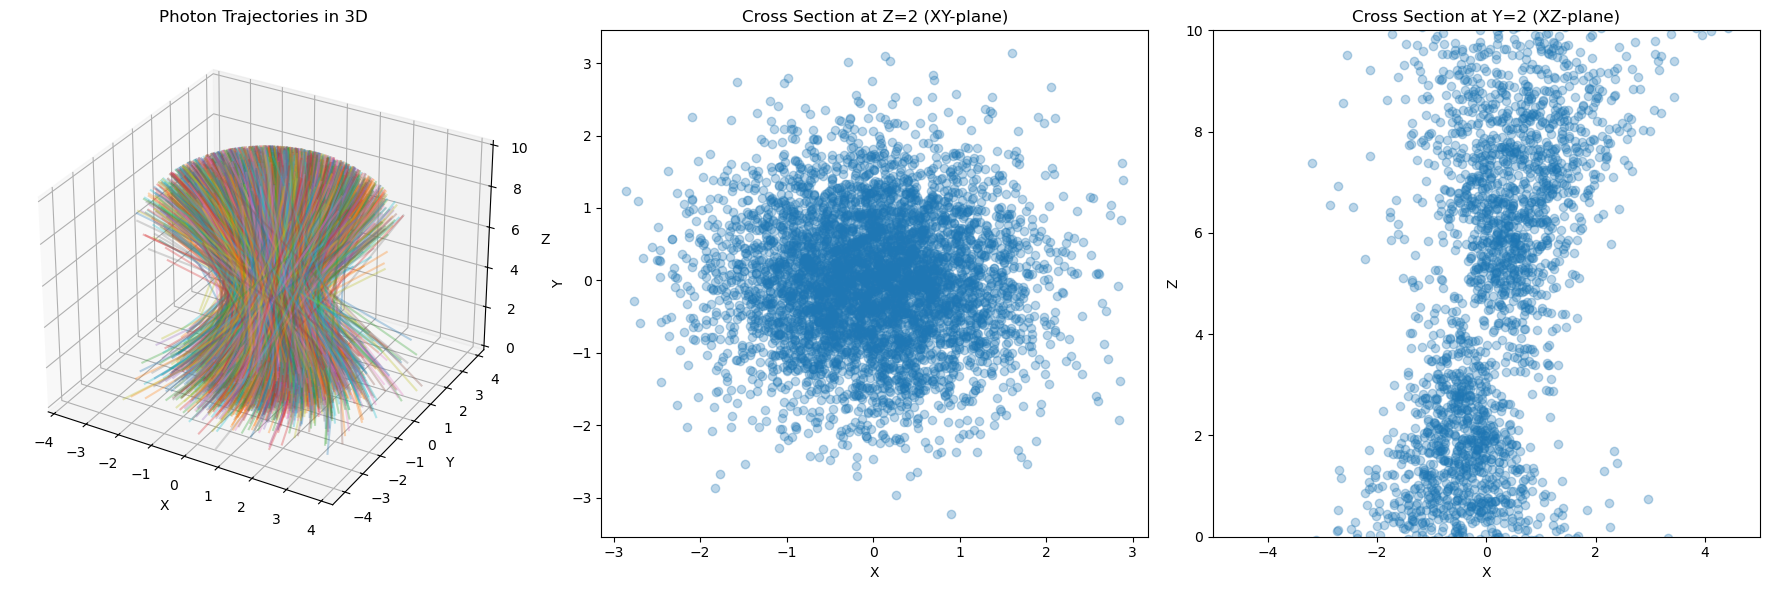

In [68]:
# Apply source position shift (translate all positions by source_pos)
xi_shifted = xi + source_pos[0]
yi_shifted = yi + source_pos[1]
zi_shifted = zi + source_pos[2]

# Define the z-plane we are interested in
z_plane = 1

# Calculate intersection points at z = 2 for each photon
x_at_z2 = xi_shifted + vx * (z_plane - zi_shifted) / vz
y_at_z2 = yi_shifted + vy * (z_plane - zi_shifted) / vz

# 3D Plot: Photon trajectories in space
fig = plt.figure(figsize=(18, 6))

# 1. 3D plot of photon trajectories
ax_3d = fig.add_subplot(131, projection='3d')
t_vals = np.linspace(0, 10, 500)  # Parameter for line length
for i in range(num_phot):
    x_line = xi_shifted[i] + vx[i] * t_vals
    y_line = yi_shifted[i] + vy[i] * t_vals
    z_line = zi_shifted[i] + vz[i] * t_vals
    ax_3d.plot(x_line, y_line, z_line, alpha=0.3)

ax_3d.set_xlabel('X')
ax_3d.set_ylabel('Y')
ax_3d.set_zlabel('Z')
ax_3d.set_title('Photon Trajectories in 3D')

# 2. Cross-sectional view at z=2 on XY-plane
ax_xy = fig.add_subplot(132)
ax_xy.scatter(x_at_z2, y_at_z2, alpha=0.3)  # Plot only the points at z=2
ax_xy.set_xlabel('X')
ax_xy.set_ylabel('Y')
ax_xy.set_title('Cross Section at Z=2 (XY-plane)')

# 3. Cross-sectional view in the XZ-plane (side view)
y_plane = 1
# Filter photons where vy is too small to avoid large values of t
epsilon = 1e-6  # Small threshold for vy
valid_photons = np.abs(vy) > epsilon  # Only keep photons with valid vy

# Calculate intersection points at y = 2 for valid photons
x_at_y2 = xi_shifted[valid_photons] + vx[valid_photons] * (y_plane - yi_shifted[valid_photons]) / vy[valid_photons]
z_at_y2 = zi_shifted[valid_photons] + vz[valid_photons] * (y_plane - yi_shifted[valid_photons]) / vy[valid_photons]

# 3. Cross-sectional view at y=2 on XZ-plane
ax_xz = fig.add_subplot(133)
ax_xz.scatter(x_at_y2, z_at_y2, alpha=0.3)  # Plot only the points at y=2
ax_xz.set_xlabel('X')
ax_xz.set_ylabel('Z')
ax_xz.set_title('Cross Section at Y=2 (XZ-plane)')
ax_xz.set_xlim([-5, 5])
ax_xz.set_ylim([0, 10])

plt.tight_layout()

# Show the plot (make sure this line is present)
plt.show()

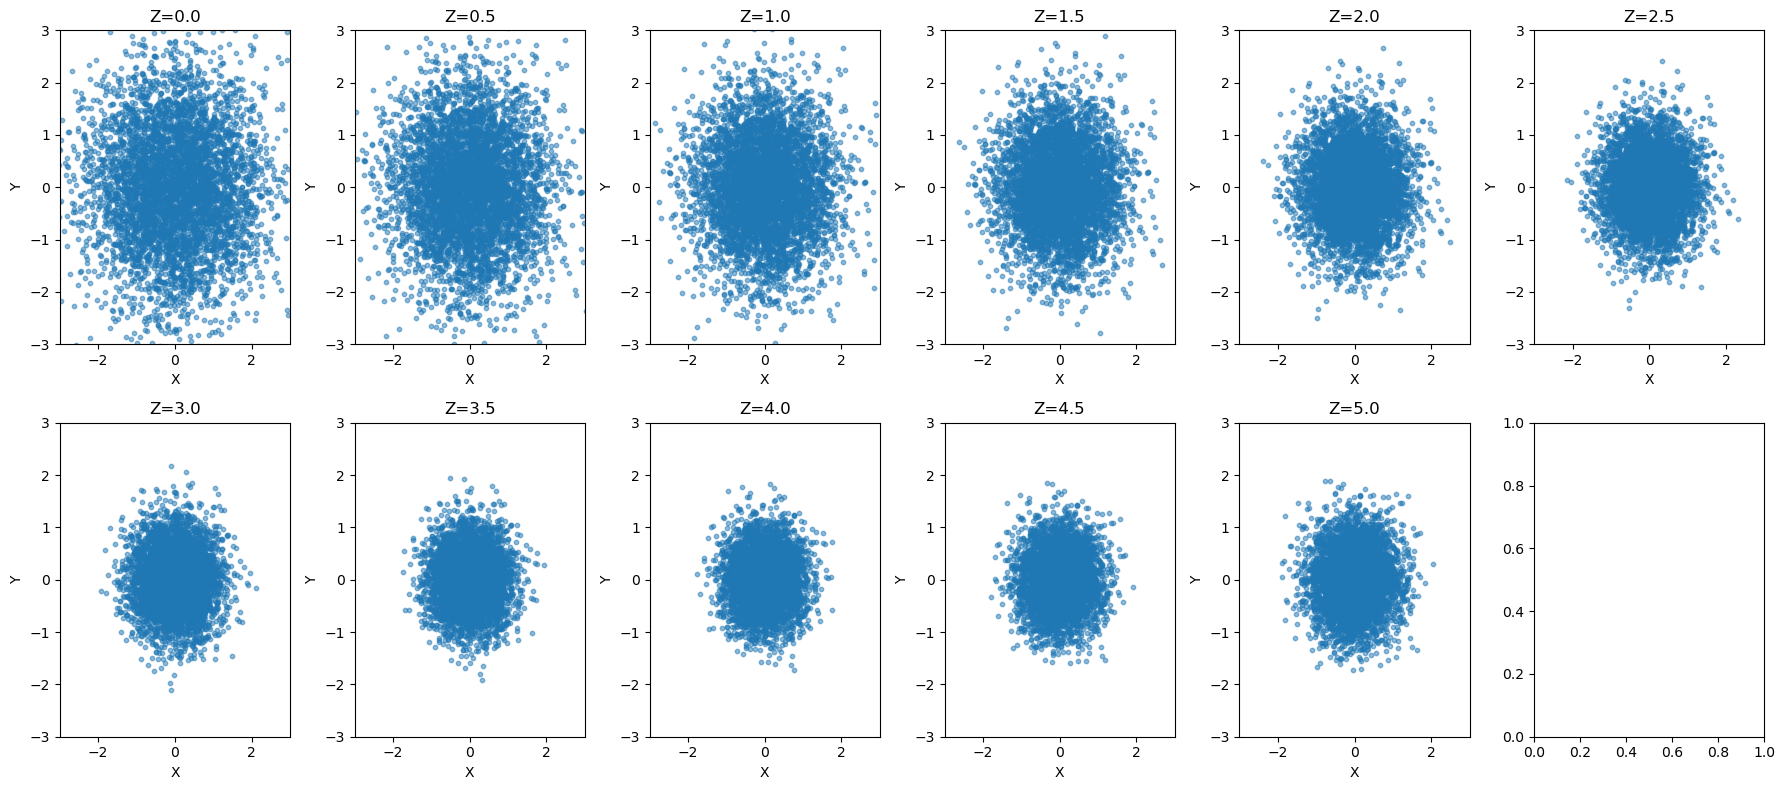

In [66]:
# Define the z values we're interested in for cross-sections (from 0 to 5 with step 0.5)
z_planes = np.arange(0, 5.5, 0.5)

# Number of subplots (2 rows, 6 columns for 12 z-planes)
nrows = 2
ncols = 6

# Set the figure size
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 8))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Set the same x and y axis limits to (-3, 3) for all subplots
x_limits = (-3, 3)
y_limits = (-3, 3)

# Loop through each z-plane and plot on a separate subplot
for idx, z_plane in enumerate(z_planes):
    # Calculate the photon positions at this z value
    x_at_z = xi_shifted + vx * (z_plane - zi_shifted) / vz
    y_at_z = yi_shifted + vy * (z_plane - zi_shifted) / vz
    
    # Scatter plot for the XY-plane at the current z-plane
    axs[idx].scatter(x_at_z, y_at_z, alpha=0.5, s=10)
    
    # Set labels and title for each subplot
    axs[idx].set_xlabel('X')
    axs[idx].set_ylabel('Y')
    axs[idx].set_title(f'Z={z_plane:.1f}')
    
    # Set the same x and y axis limits for all subplots
    axs[idx].set_xlim(x_limits)
    axs[idx].set_ylim(y_limits)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
